### Import data

In [146]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import dateutil.parser
import seaborn as sns
from IPython.display import Image
import os

fil_path = "../data/srt/srt_csv/"
dir_list = os.listdir(fil_path)

''' Settings '''
sns.set_style("white")
pd.set_option('display.max_columns', 50)
pd.set_option('display.max_rows', 20)
pd.set_option('display.precision', 3)

''' Load and concatinate CSV files into single dataframe'''

files=[]
for path in dir_list:
    files.append(
        pd.read_csv(fil_path+path,index_col=0)
    )
df_sub = pd.concat(files)

csv_names = ['../data/imdb_unique_prod-2018-04-21_0924.csv']
files = []
for path in csv_names:
    files.append(
        pd.read_csv(path,index_col=0)
    )
df_movies = pd.concat(files)

# Clean out unnamed column
df_movies = df_movies.loc[:, ~df_movies.columns.str.contains('^Unnamed')]


In [147]:
df_sub['line_duration'] = df_sub['endTime'] - df_sub['startTime']
df_sub['line_delta'] = df_sub['startTime'] - df_sub['endTime'].shift(1)
df_sub['line_delta'] = df_sub['line_delta'].fillna(0).astype(int)
df_sub['line_duration'] = df_sub['line_duration'].fillna(0).astype(int)
#df_movies['genre'] = df_movies['genre'].dropna()
df_submov = pd.merge(df_sub, df_movies, on='title')

x = df_submov['genre'].str.split('\s*,\s*', expand=True).stack()
df_new = pd.crosstab(x.index.get_level_values(0), x.values).iloc[:, 1:]
df_submov = df_submov.join(df_new)

In [111]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

<Container object of 0 artists>

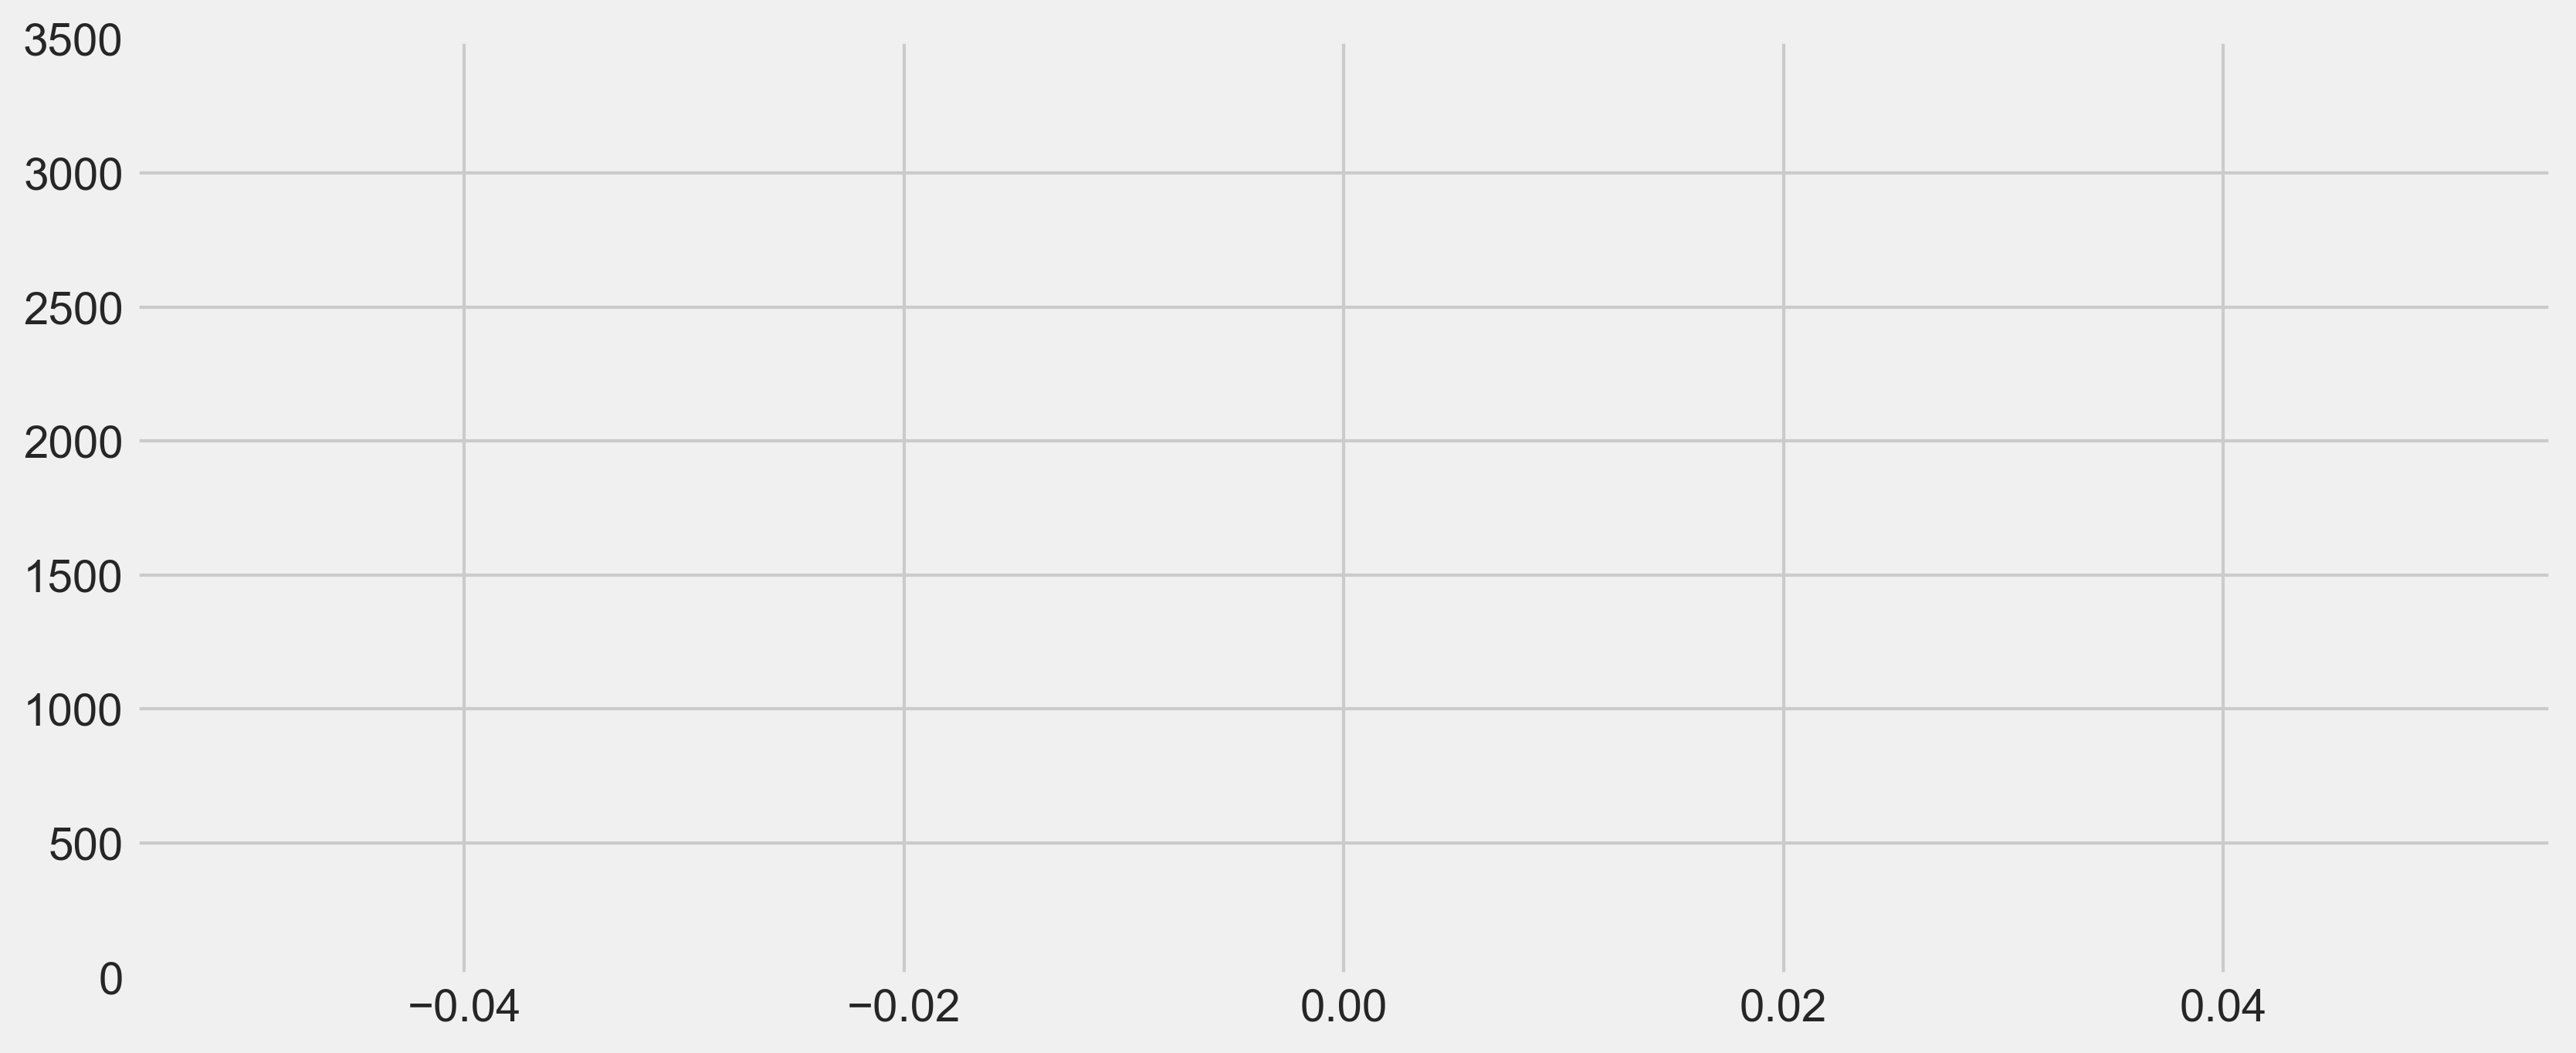

In [151]:
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import datetime
from matplotlib.cm import bwr as cmap
import matplotlib.patches as mpatches
plt.style.use('fivethirtyeight')
# setting  figure size
plt.figure(figsize=(12,5))
axes = plt.gca()
#axes.set_xlim([xmin,xmax])
axes.set_ylim([0,3500])
#df_submov_bytitle = df_submov.groupby('title').agg(lambda x: x[x>0].mean()).reset_index()
#df_submov_bytitle = df_submov_bytitle.fillna(0)
df_test = df_submov[df_submov['title'] == "Moonlight"]
df_test['startTime'] = df_test['startTime'].astype(float)
df_test['lduration_timestamp'] = (df_test['startTime']/1000.0)/60
df_test['lduration_timestamp'] = df_test['lduration_timestamp'].astype(int)
#df_test['lduration_timestamp'] = df_test['lduration_timestamp'].astype(int)
df_test = df_test.groupby('lduration_timestamp').mean()
#df_test['duration_min'] = (df_test['line_duration']/1000)/60
#df_submov_bytitle.groupby([df['startTime'],pd.TimeGrouper(freq='Min')])
#df_test.to_csv('../data/toprocess.csv')
plt.bar(x=df_test.index,height=df_test['line_duration'])

In [93]:
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from matplotlib.cm import bwr as cmap
import matplotlib.patches as mpatches

# setting  figure size
plt.figure(figsize=(12,5))
 
# setting colors. Maps the max and min values
# in "diff" to a color map bwr.
c_normal = colors.PowerNorm(1,vmin=min(df_test["line_duration"]),vmax=max(df_test["line_duration"]))
#_COLORS = cmap(c_normal(df_submov_bytitle["line_delta"]))

plt.bar(np.arange(len(df_test["line_delta"])),
height = df_test["line_delta"], width = 0.01, align = "center")
plt.xticks(np.arange(len(df_test['line_delta'].index)),list(df_test['line_delta'].index))
plt.axhline(0, color='k', linewidth = 0.-1)
plt.xlabel("State")
plt.ylabel("Median Performance Difference\n(Boys - Girls)")

# creating legend patches
red_patch = mpatches.Patch(color='red', label='Boys Perform Better')
blue_patch = mpatches.Patch(color='blue', label='Girls Perform Better')
plt.legend(handles=[red_patch, blue_patch], loc=4)
 
plt.show()

KeyError: 'line_duration'

In [61]:
def plot_yearly_durations():
    # Categorize genres
    plt.style.use('fivethirtyeight')
    df_sub['line_duration'] = df_sub['endTime'] - df_sub['startTime']
    df_sub['line_delta'] = df_sub['startTime'] - df_sub['endTime'].shift(1)
    df_sub['line_delta'] = df_sub['line_delta'].fillna(0).astype(int)
    #df_movies['genre'] = df_movies['genre'].dropna()
    df_submov = pd.merge(df_sub, df_movies, on='title')
   
    x = df_submov['genre'].str.split('\s*,\s*', expand=True).stack()
    df_new = pd.crosstab(x.index.get_level_values(0), x.values).iloc[:, 1:]
    df_submov = df_submov.join(df_new)
    
    df_submov = df_submov[(df_submov['year']>1950) & (df_submov['Adventure'] == 1)]
    df_submov_byyear = df_submov.groupby('year').agg(lambda x: x[x>0].median())
    #df_submov_byyear = df_submov.groupby('year').agg(lambda x: x[x>0].mean())
    df_submov_byyear = df_submov_byyear.reset_index()
    df_submov_byyear.plot(x='year',y='line_duration',figsize=(15,10),xticks=df_submov_byyear['year'],rot=-65)
plot_yearly_durations()

UnboundLocalError: local variable 'df_submov' referenced before assignment

### Clean Data

In [2]:
from currency_converter import CurrencyConverter
from re import sub
import math

# Parse currencies

c = CurrencyConverter()
def parse_currency(value):
    value = str(value)
    currency_type = sub(r'[?!^\d.]', '', value ).replace(',','').rstrip()
    currency_amount = sub(r'[^\d.]', '', value)
    if currency_type == "$":
        currency_type = 'USD'
    if currency_type == "€":
        currency_type = 'EUR'
    if currency_type == "£":
        currency_type = 'GBP'
    if currency_type == "RUR":
        currency_type = 'USD'
    if currency_type == "FRF":
        currency_type = 'EUR'
    if currency_type == "DEM":
        currency_type = 'EUR'
    if currency_type == "":
        currency_type = 'USD'        
    return int(math.ceil(c.convert(currency_amount, currency_type, 'USD')))    

''' Turn currency strings to floats '''

df_movies = df_movies[df_movies['gross_usa'].notnull()]
df_movies = df_movies[df_movies['gross_usa_weekend'].notnull()]
df_movies = df_movies[df_movies['gross_worldwide'].notnull()]
df_movies = df_movies[df_movies['budget'].notnull()]
df_movies['budget'] = df_movies['budget'].apply(parse_currency)
df_movies['gross_usa'] = df_movies['gross_usa'].apply(parse_currency)
df_movies['gross_usa_weekend'] = df_movies['gross_usa_weekend'].apply(parse_currency)
df_movies['gross_worldwide'] = df_movies['gross_worldwide'].apply(parse_currency)


''' Generate time data'''

# Calculate length of line dialogue
df_sub['line_duration'] = df_sub['endTime'] - df_sub['startTime']

# Calculate length of silence between dialouge
df_sub['line_delta'] = df_sub['startTime'] - df_sub['endTime'].shift(1)
df_sub['line_delta'] = df_sub['line_delta'].fillna(0).astype(int)
#df_movies['genre'] = df_movies['genre'].dropna()

''' Merge subtitle and movie dataframe '''

df_submov = pd.merge(df_sub, df_movies, on='title')
#df_submov = df_submov.sort_values(by='imdb_rating')
#df_submov = df_submov[['title','year','line_duration','line_delta','startTime']]
#df_submov.head(50).to_csv('../data/processing.csv')

ValueError: shape mismatch: objects cannot be broadcast to a single shape

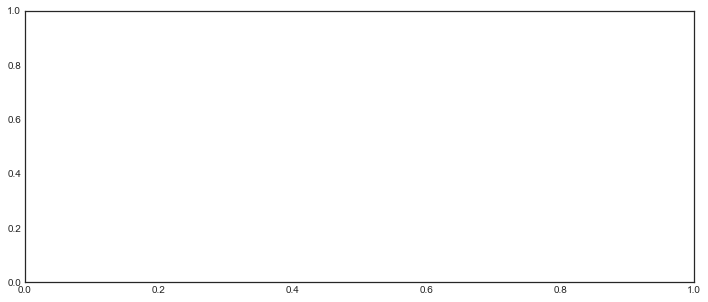

In [3]:
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from matplotlib.cm import bwr as cmap
import matplotlib.patches as mpatches

# setting  figure size
plt.figure(figsize=(12,5))

# setting colors. Maps the max and min values
# in "diff" to a color map bwr.
df_vertigo = df_submov[df_submov['title']=="Vertigo"]
c_normal = colors.PowerNorm(1,vmin=min(df_vertigo["line_delta"]),vmax=max(df_vertigo["line_delta"]))
#_COLORS = cmap(c_normal(df_submov["line_delta"]))
plt.bar(np.arange(len(df_vertigo["line_delta"])),
height = df_submov["line_delta"], width = 0.75, align = "center")
plt.xticks(np.arange(len(df_vertigo.index)),list(df_vertigo.index))
plt.axhline(0, color='k', linewidth = 0.5)
plt.xlabel("State")
plt.ylabel("Median Performance Difference\n(Boys - Girls)")

# creating legend patches
red_patch = mpatches.Patch(color='red', label='Boys Perform Better')
blue_patch = mpatches.Patch(color='blue', label='Girls Perform Better')
plt.legend(handles=[red_patch, blue_patch], loc=4)

plt.show()

### Parse and merge categoricals

In [4]:
import patsy
# Categorize genres
x = df_submov['genre'].str.split('\s*,\s*', expand=True).stack()
df_new = pd.crosstab(x.index.get_level_values(0), x.values).iloc[:, 1:]
df_submov = df_submov.join(df_new)

# Categorize mpaaa
x = df_submov['mpaa_rating'].str.split('\s*,\s*', expand=True).stack()
df_new = pd.crosstab(x.index.get_level_values(0), x.values).iloc[:, 1:]
df_submov = df_submov.join(df_new)

# Categorize color
x = df_submov['color'].str.split('\s*,\s*', expand=True).stack()
df_new = pd.crosstab(x.index.get_level_values(0), x.values).iloc[:, 1:]
df_submov = df_submov.join(df_new)

# Categorize country
x = df_submov['country'].str.split('\s*,\s*', expand=True).stack()
df_new = pd.crosstab(x.index.get_level_values(0), x.values).iloc[:, 1:]
df_submov = df_submov.join(df_new)

# Categorize language
x = df_submov['language'].str.split('\s*,\s*', expand=True).stack()
df_new = pd.crosstab(x.index.get_level_values(0), x.values).iloc[:, 1:]
df_submov = df_submov.join(df_new)

''' legacy -- patsy'''
#df_submov['genre'] = df_submov['genre'].str.split(',').str[0]
#X=patsy.dmatrix('genre',data=df_submov,return_type='dataframe')
#df_submov.join(X).groupby('title').mean()

' legacy -- patsy'

### Save/Load Dataframe

In [ ]:
df_submov.to_pickle('../data/df_submove-2018-04-25-0322.pkl')

In [ ]:
df_submov = pd.read_pickle('../data/df_submove-2018-04-25-0322.pkl')

### Group by title

In [5]:
df_submov_bytitle = df_submov.groupby('title').agg(lambda x: x[x>0].mean())
df_submov_bytitle = df_submov_bytitle.fillna(0)
df_submov_bytitle

startTime    endTime  line_duration  line_delta  \
title                                                                     
101 Dalmatians          2.744e+06  2.747e+06       2766.305    4178.950   
12 Years a Slave        3.806e+06  3.808e+06       2086.765    3266.731   
13 Hours                3.824e+06  3.826e+06       1859.239    1662.304   
2 Fast 2 Furious        3.092e+06  3.094e+06       2251.820    3314.502   
2 Guns                  2.942e+06  2.944e+06       1787.000    1975.299   
21 Jump Street          3.117e+06  3.119e+06       1991.098    1187.751   
27 Dresses              3.153e+06  3.155e+06       2810.894     729.845   
3 Idiots                4.984e+06  4.987e+06       2574.651    2125.816   
3 Men and a Baby        2.840e+06  2.843e+06       2940.515    1286.517   
300: Rise of an Empire  2.548e+06  2.551e+06       2575.330    5100.167   
...                           ...        ...            ...         ...   
X-Men: The Last Stand   2.559e+06  2.562e+06       3091.387    5083.095   
Yes Man                 2.874e+06  2.876e+06       2638.612    1634.869   
Yogi Bear               2.133e+06  2.136e+06       2358.601    1270.793   
You've Got Mail         3.339e+06  3.341e+06       2103.254    1708.496   
You, Me and Dupree      2.934e+06  2.937e+06       2362.670    1422.191   
Zero Dark Thirty        4.014e+06  4.016e+06       2205.522    3427.994   
Zombieland              2.331e+06  2.333e+06       2577.398    2980.739   
Zookeeper               2.674e+06  2.676e+06       2438.303    1567.604   
Zootopia                2.983e+06  2.985e+06       2162.117    1335.820   
xXx                     3.094e+06  3.096e+06       2856.549    5056.432   

                           budget  gross_usa  gross_usa_weekend  \
title                                                             
101 Dalmatians           75000000  136189294           45073479   
12 Years a Slave         20000000   56671993             923715   
13 Hours                 50000000   52853219           16000000   
2 Fast 2 Furious         76000000  127154901           50472480   
2 Guns                   61000000   75612460           27059130   
21 Jump Street           42000000  138447667           36302612   
27 Dresses               30000000   76808654           27442040   
3 Idiots                  8564290    6532908            1645502   
3 Men and a Baby         11000000  167780960           10384392   
300: Rise of an Empire  110000000  106580051           45038460   
...                           ...        ...                ...   
X-Men: The Last Stand   210000000  234362463          122861157   
Yes Man                  70000000   97690976           18262471   
Yogi Bear                80000000  100246011           16411322   
You've Got Mail          65000001  115821495           18426749   
You, Me and Dupree       54000000   75628110           21525560   
Zero Dark Thirty         40000000   95720716             417150   
Zombieland               23600000   75590286           24733155   
Zookeeper                80000000   80360843           20065617   
Zootopia                150000000  341268248           75063401   
xXx                      70000000  142109382           44506103   

                        gross_worldwide  imdb_critic_reviews_total  \
title                                                                
101 Dalmatians                320689294                       56.0   
12 Years a Slave              187733202                      601.0   
13 Hours                       69411370                      232.0   
2 Fast 2 Furious              107376378                      154.0   
2 Guns                        131940411                      270.0   
21 Jump Street                201585328                      376.0   
27 Dresses                    160259319                      174.0   
3 Idiots                       80000000                       52.0   
3 Men and a Baby              242780960                 

### REMOVE START END TIMES (OPTIONAL)

In [7]:
df_submov_bytitle = df_submov_bytitle[df_submov_bytitle.columns.difference(['startTime','endTime'])]

### Plot Correlation

Adventure  Animation  Biography  Canada  China  \
Adventure                      1.000      0.377     -0.186  -0.032  0.049   
Animation                      0.377      1.000     -0.095  -0.038  0.026   
Biography                     -0.186     -0.095      1.000  -0.025 -0.018   
Canada                        -0.032     -0.038     -0.025   1.000 -0.007   
China                          0.049      0.026     -0.018  -0.007  1.000   
Color                          0.062      0.064     -0.056   0.017  0.012   
Comedy                         0.028      0.389     -0.158  -0.004 -0.021   
Crime                         -0.252     -0.142     -0.027  -0.045  0.016   
Drama                         -0.322     -0.208      0.326   0.027 -0.054   
Family                         0.410      0.689     -0.110   0.005  0.004   
...                              ...        ...        ...     ...    ...   
gross_usa                      0.377      0.131     -0.104  -0.012  0.068   
gross_usa_weekend              0.398      0.073     -0.176   0.016  0.118   
gross_worldwide                0.430      0.166     -0.114  -0.019  0.143   
imdb_critic_reviews_total      0.185     -0.092      0.071  -0.009  0.072   
imdb_rating                   -0.060     -0.011      0.185  -0.021  0.015   
line_delta                     0.046     -0.023     -0.013  -0.004  0.052   
line_duration                 -0.059     -0.032     -0.035  -0.028 -0.031   
metacritic_rating              0.101      0.091      0.065  -0.016  0.037   
runtime                       -0.060     -0.354      0.160  -0.009  0.021   
year                           0.119      0.112      0.062   0.042  0.068   

                           Color  Comedy  Crime  Drama     Family    Fantasy  \
Adventure                  0.062   0.028 -0.252 -0.322  4.100e-01  4.077e-01   
Animation                  0.064   0.389 -0.142 -0.208  6.885e-01  3.747e-01   
Biography                 -0.056  -0.158 -0.027  0.326 -1.096e-01 -1.334e-01   
Canada                     0.017  -0.004 -0.045  0.027  5.486e-03 -2.364e-02   
China                      0.012  -0.021  0.016 -0.054  3.869e-03  4.523e-03   
Color                      1.000   0.073 -0.027 -0.046  7.261e-02  5.326e-02   
Comedy                     0.073   1.000 -0.037 -0.282  4.274e-01  1.265e-01   
Crime                     -0.027  -0.037  1.000  0.036 -1.955e-01 -2.086e-01   
Drama                     -0.046  -0.282  0.036  1.000 -2.421e-01 -2.120e-01   
Family                     0.073   0.427 -0.196 -0.242  1.000e+00  4.703e-01   
...                          ...     ...    ...    ...        ...        ...   
gross_usa                  0.070  -0.061 -0.149 -0.193  1.107e-01  2.592e-01   
gross_usa_weekend          0.093  -0.082 -0.114 -0.301  6.706e-02  2.532e-01   
gross_worldwide            0.063  -0.124 -0.160 -0.186  1.329e-01  3.058e-01   
imdb_critic_reviews_total  0.063  -0.334 -0.070  0.038 -1.867e-01  4.897e-02   
imdb_rating               -0.104  -0.335  0.098  0.309 -1.865e-01 -1.003e-01   
line_delta                 0.008  -0.050 -0.007 -0.030 -3.110e-02  6.394e-02   
line_duration             -0.064  -0.048  0.009  0.043 -1.126e-04  2.598e-02   
metacritic_rating         -0.036  -0.106 -0.076  0.105  2.188e-02 -9.830e-04   
runtime                   -0.101  -0.473  0.059  0.301 -3.593e-01 -1.382e-01   
year                       0.176   0.072 -0.063 -0.059  8.996e-02  1.247e-01   

                           Film-Noir  Finland  France     French    Germany  \
Adventure                     -0.042    0.042  -0.043 -2.935e-02 -1.902e-02   
Animation                     -0.019    0.092  -0.033 -1.349e-02 -1.637e-02   
Biography                     -0.012   -0.009  -0.022 -8.771e-03  1.313e-02   
Canada                        -0.005   -0.004  -0.009  3.520e-01 -1.231e-02   
China                         -0.004   -0.002  -0.006 -2.489e-03 -8.682e-03   
Color                         -0.145    0.006   0.015  5.904e-03 -4.228e-02   
Comedy            

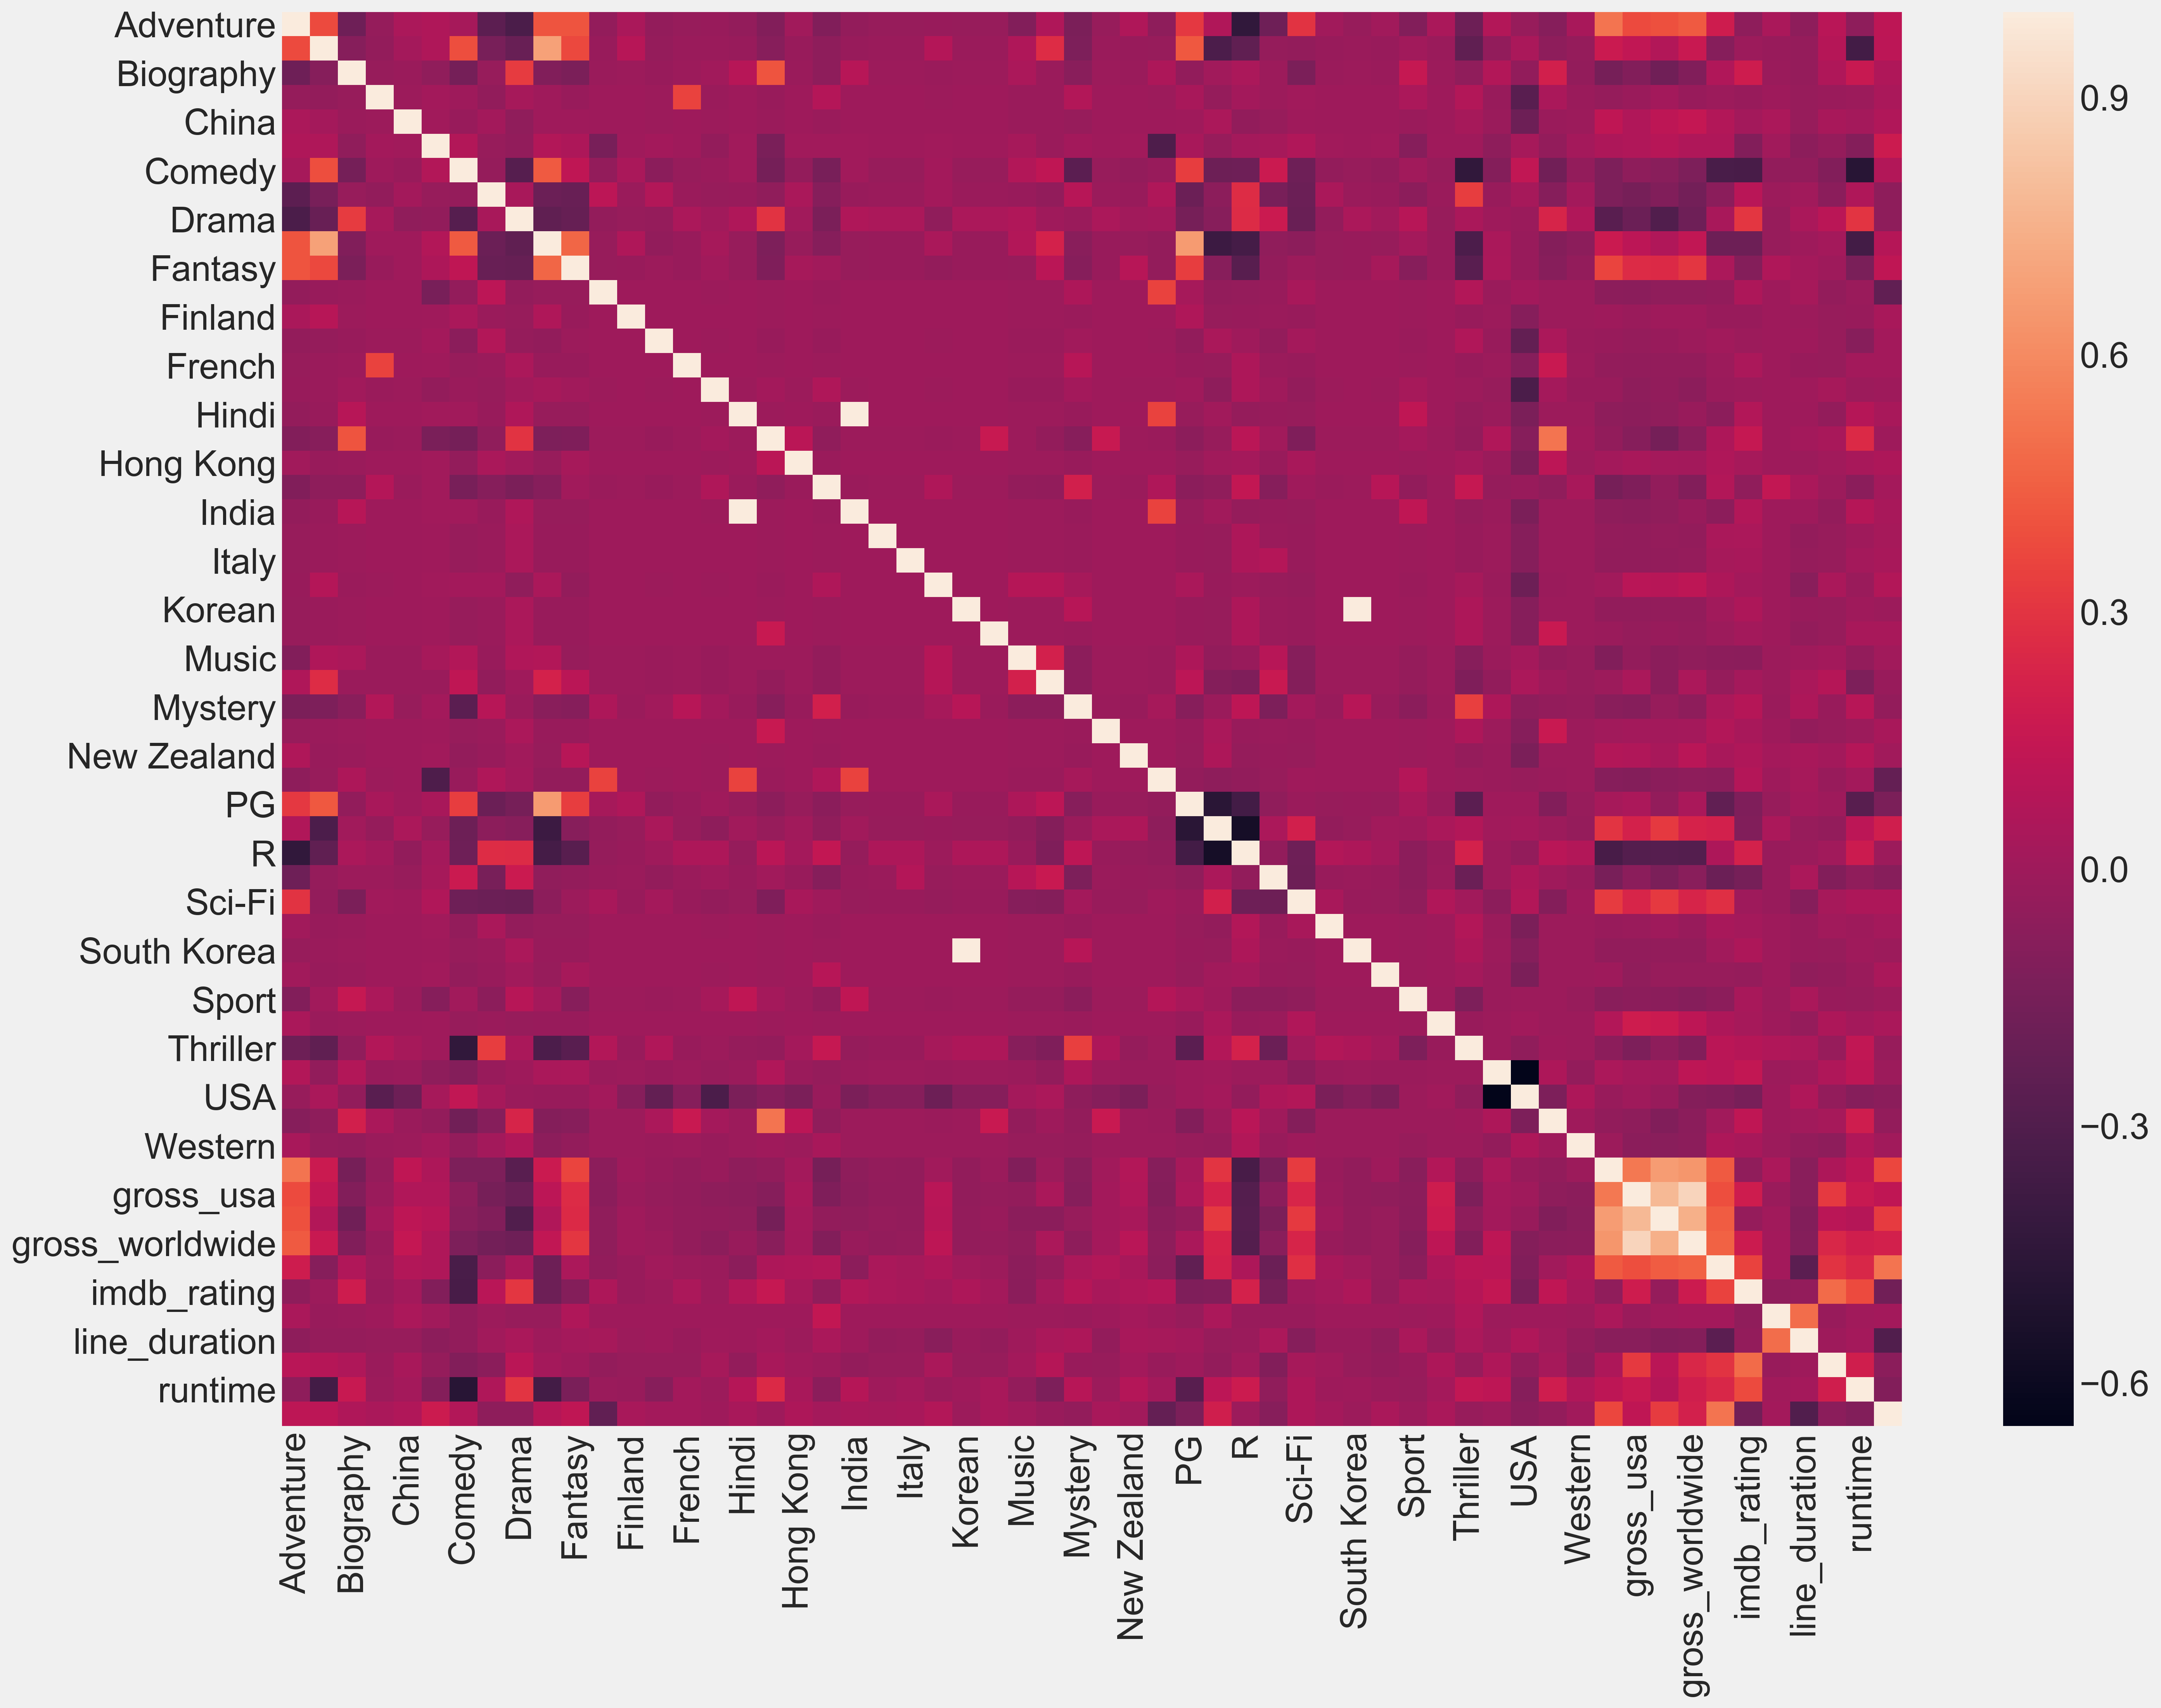

In [8]:
from matplotlib import rcParams
rcParams['figure.dpi'] = 300
plt.style.use('fivethirtyeight')
plt.rcParams.update({'font.size': 22})
plt.subplots(figsize=(20,15))
sns.heatmap(df_submov_bytitle.corr())
df_submov_bytitle.corr()

### Fix Categoricals

In [9]:
df_submov_bytitle['SciFi'] = df_submov_bytitle['Sci-Fi']
df_submov_bytitle['FilmNoir'] = df_submov_bytitle['Film-Noir']
df_submov_bytitle['PG13'] = df_submov_bytitle['PG-13']
df_submov_bytitle['NotRated'] = df_submov_bytitle['Not Rated']
df_submov_bytitle['HongKong'] = df_submov_bytitle['Hong Kong']
df_submov_bytitle['SouthKorea'] = df_submov_bytitle['South Korea']
df_submov_bytitle['SouthAfrica'] = df_submov_bytitle['South Africa']
df_submov_bytitle['NewZealand'] = df_submov_bytitle['New Zealand']
df_submov_bytitle = df_submov_bytitle.drop(['Sci-Fi','Film-Noir','PG-13','Not Rated','South Africa','South Korea','Hong Kong','New Zealand'],axis=1) 

# Modeling

In [78]:
df_submov_bytitle.count()

Adventure      806
Animation      806
Biography      806
Canada         806
China          806
Color          806
Comedy         806
Crime          806
Drama          806
Family         806
              ... 
runtime        806
year           806
SciFi          806
FilmNoir       806
PG13           806
NotRated       806
HongKong       806
SouthKorea     806
SouthAfrica    806
NewZealand     806
Length: 58, dtype: int64

In [10]:
import statsmodels.api as sm
import statsmodels.formula.api as smf
import patsy

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import RidgeCV

import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.sandbox.regression.predstd import wls_prediction_std
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold

/Users/justinblinder/anaconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [17]:
# Formula variables
#countries_formula = "+Canada+China+Finland+France+Germany+HongKong+India+Ireland+Italy+Japan+Netherlands+NewZealand+SouthAfrica+SouthKorea+Spain+UK+USA+Malta"
language_formula  = "+French+Hindi+Korean+Swahili"
imdb_formula      = "year + budget+gross_usa + gross_usa_weekend + gross_worldwide + imdb_rating+imdb_critic_reviews_total + runtime"
genre_formula     = "+Adventure+Animation+Biography+Color+Comedy+Crime+Drama+Family+Fantasy+FilmNoir+History+Horror+Music+Musical+Mystery+Romance+SciFi+Sport+Thriller+War+Western"
ratings_formula   = "+R+PG13+NotRated"

# Countries not helping
#regression_formula = imdb_formula + genre_formula + ratings_formula + countries_formula + language_formula
#regression_formula = imdb_formula + genre_formula + ratings_formula + language_formula
#regression_formula = imdb_formula + genre_formula + ratings_formula
regression_formula = imdb_formula + genre_formula #+"+("imdb_formula

In [11]:
df_submov_bytitle.to_pickle('../data/pre_regression-df_submov_bytitle.pkl')

In [ ]:
df_submov_bytitle.from_pickle('../data/pre_regression-df_submov_bytitle.pkl')

## Using SKLearn

In [26]:
from sklearn import preprocessing, linear_model, pipeline
from sklearn.preprocessing import StandardScaler

# start with a clean model
df_model = df_submov_bytitle.copy()
# Filter data

df_model = df_model[(df_model['year'] > 1970)  & 
                             (df_model['line_duration'] <8000)]


# Scale data
# NOTE: Malick says not to scale in my case(4/26)
# ASK: should i scale
'''
#scalar = StandardScaler()
#df_scaled = scalar.fit_transform(df_submov_bytitle)
#df_scaled = pd.DataFrame(df_scaled,columns=df_submov_bytitle.columns)
'''

# Create patsy matrix and linear regression model
y, X = patsy.dmatrices("line_duration ~"+regression_formula, data=df_model, return_type="dataframe")
lr = LinearRegression()
model = lr.fit(X,y)

# ASK: Score and predict
# as long as you have the same have the same index should be good
score = lr.score(X,y)
predict = lr.predict(X.iloc[1].reshape(1, -1))
actual  = df_model.iloc[1]['line_duration']

df_model.iloc[1]
print(f'score={score}, predict={predict}, actual={actual}')

#fig = plt.figure(figsize=(15,15))
#fig = sm.graphics.plot_regress_exog(model, "year", fig=fig)

score=0.2063597348102585, predict=[[2275.11667435]], actual=2086.765141318977


/Users/justinblinder/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:30: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead


In [33]:
from sklearn import preprocessing, linear_model, pipeline
from sklearn.preprocessing import StandardScaler

# start with a clean model
df_submov_bytitle
df_model = df_submov_bytitle.copy()
# Filter data
#genres = [""
#df_model = df_model[(df_model['year'] > 1980)  & (df_model['line_duration'] <8000) & df_model['SciFi'] == 1]
df_model = df_model[(df_model['year'] > 1980)  & (df_model['line_duration'] <8000)]
df_model
#df_submov_bytitle = df_submov_bytitle.drop('title',axis=1)

# Scale data
# NOTE: Malick says not to scale in my case(4/26)
# ASK: should i scale
'''
#scalar = StandardScaler()
#df_scaled = scalar.fit_transform(df_submov_bytitle)
#df_scaled = pd.DataFrame(df_scaled,columns=df_submov_bytitle.columns)
'''

# Create patsy matrix and linear regression model
y, X = patsy.dmatrices("line_duration ~"+regression_formula, data=df_model, return_type="dataframe")
lr = LinearRegression()
model = lr.fit(X,y)

# ASK: Best way to  predict, match index if i don't have the title
score = lr.score(X,y)
predict = lr.predict(X.iloc[1].reshape(1, -1))
actual  = df_model.iloc[1]['line_duration']

df_model.iloc[1]
print(f'score={score}, predict={predict}, actual={actual}')

#fig = plt.figure(figsize=(15,15))
#fig = sm.graphics.plot_regress_exog(model, "year", fig=fig)

# ASK: Is it ok to have start and stop time

score=0.20265619710363658, predict=[[2285.39490184]], actual=2086.765141318977


/Users/justinblinder/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:30: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead


## Using statsmodels

score=0.20265619710363658, predict=[[2285.39490184]], actual=1911.893111638955


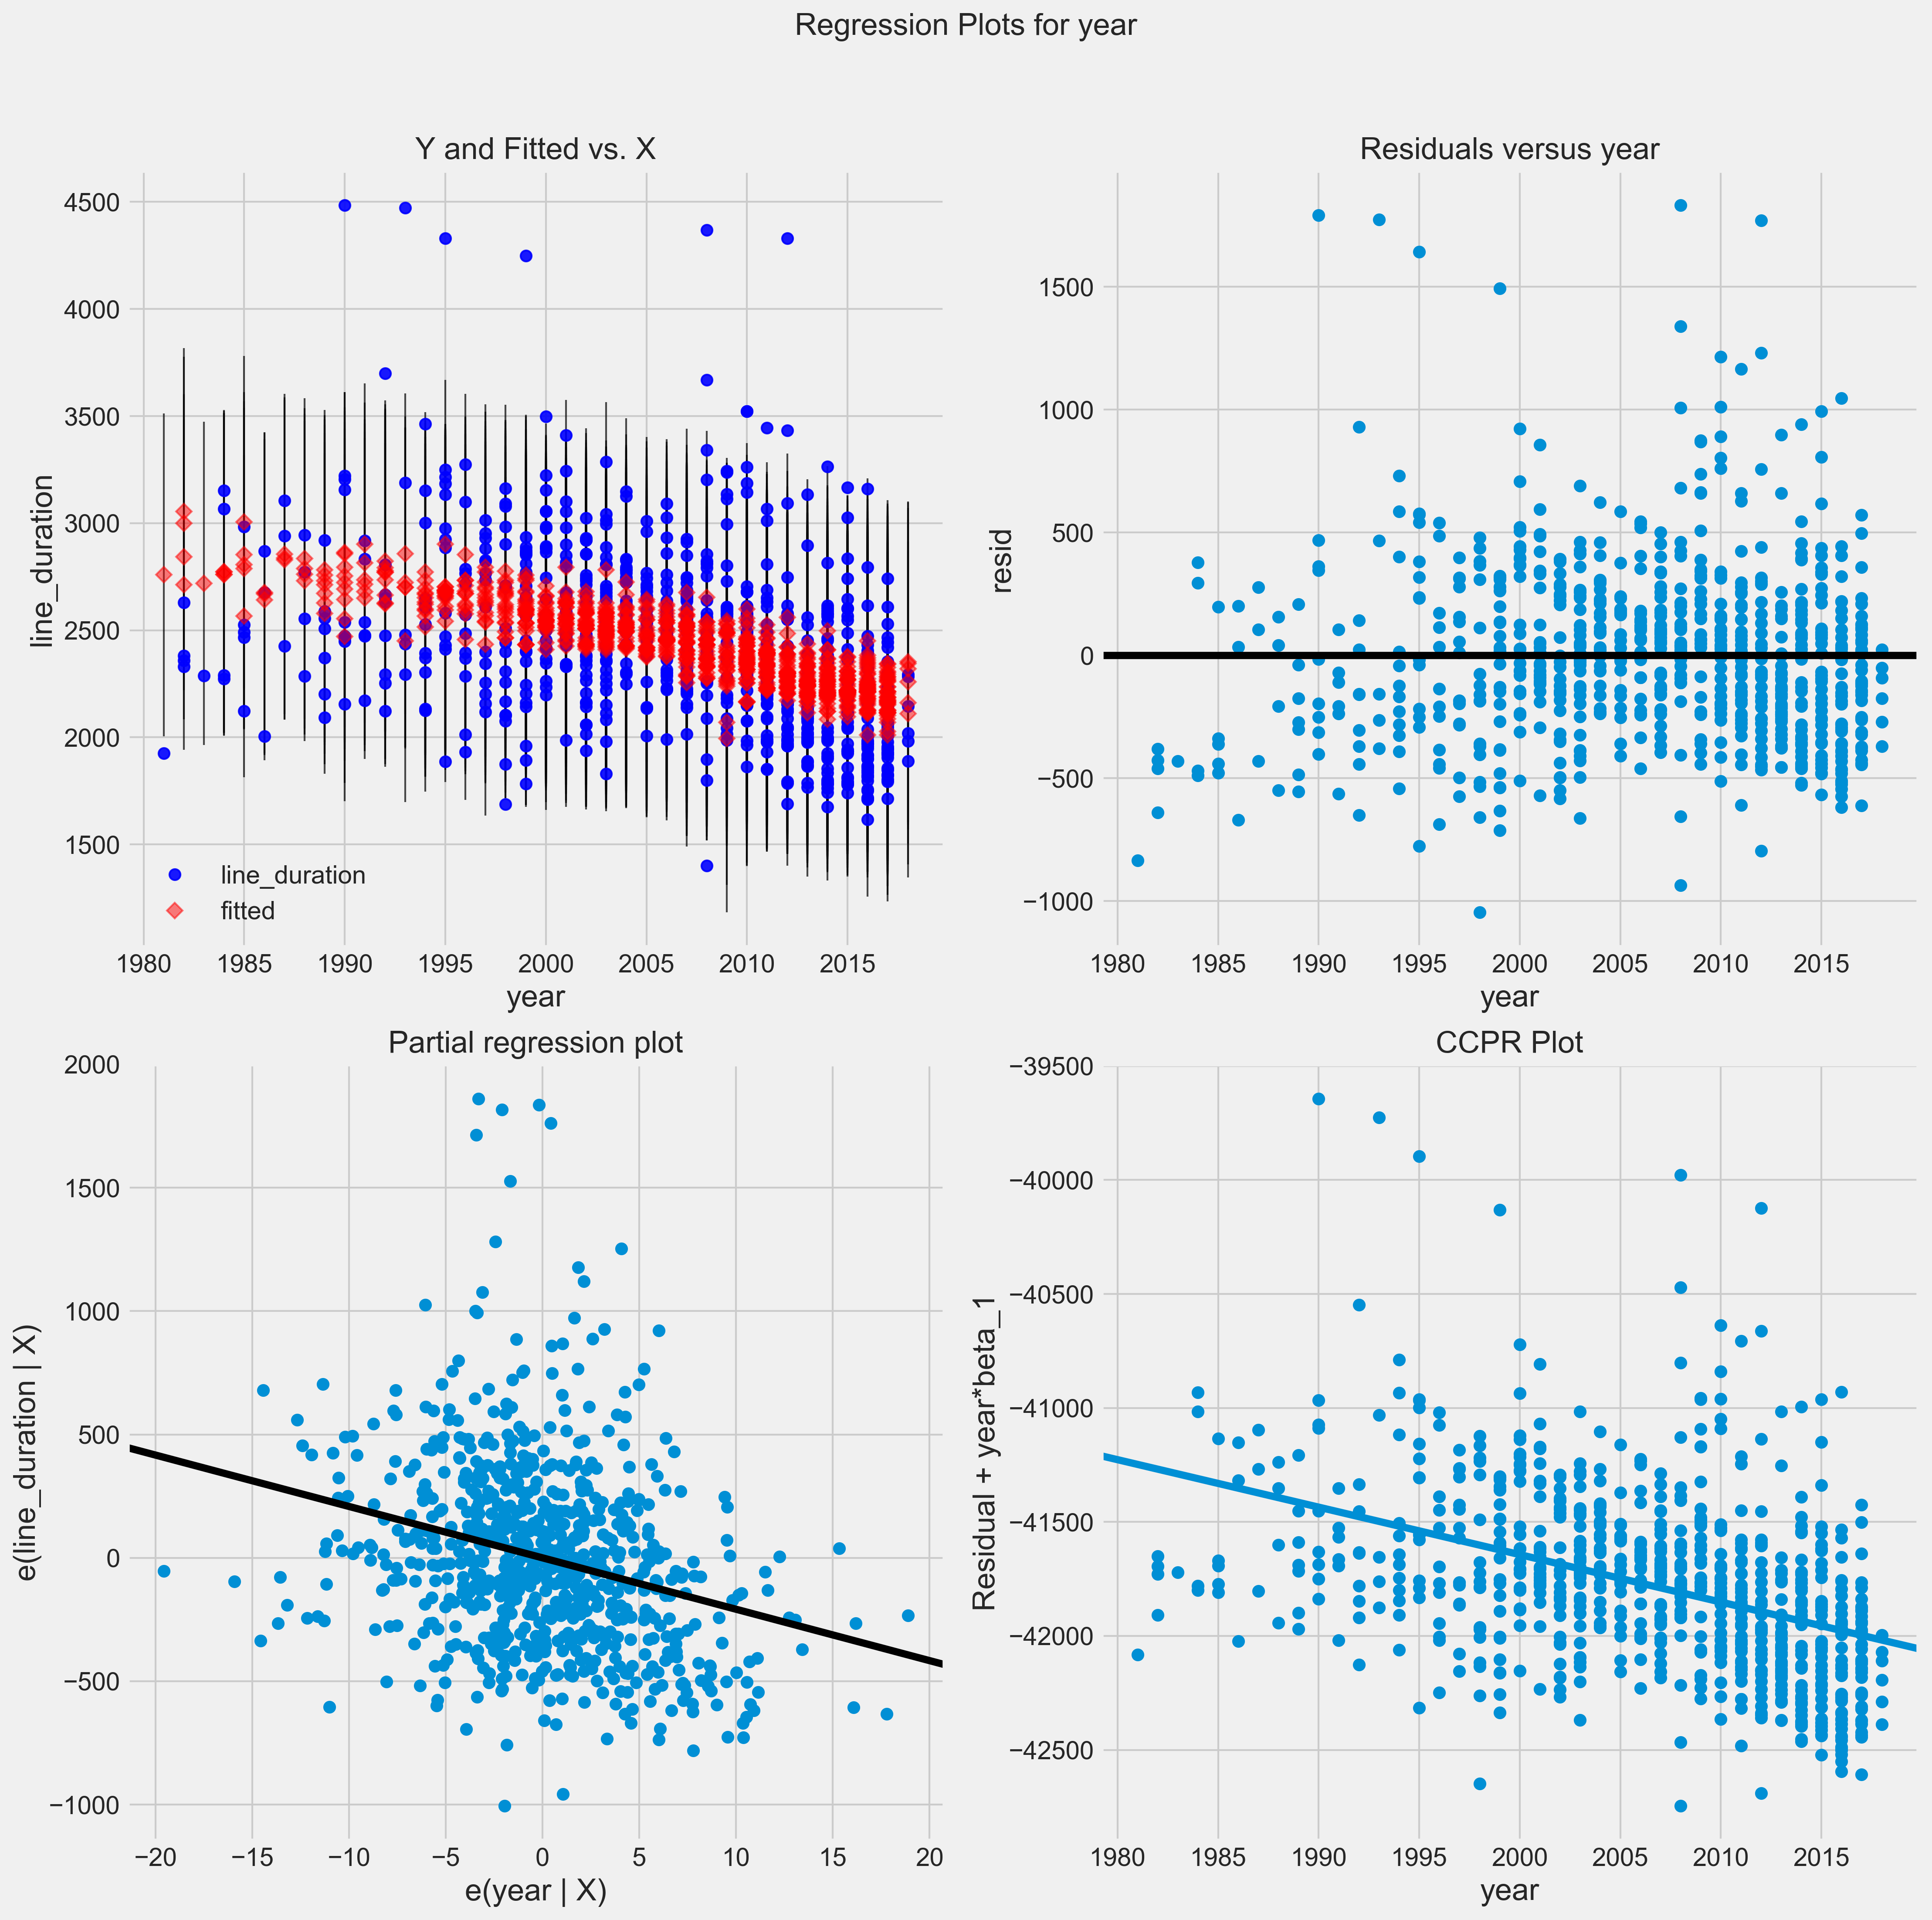

In [32]:
from matplotlib import rcParams

# Setup Styles
rcParams['figure.figsize'] = 15,8
rcParams['figure.dpi'] = 300
plt.style.use('fivethirtyeight')

# Filter data
df_r = df_submov_bytitle.copy()
df_r = df_r[(df_r['line_duration'] <  8000)]
df_r = df_r[df_r.columns.difference(['startTime','endTime'])]

# Create an empty model
df_r = df_r.reset_index()
df_r = df_r.drop('title',axis=1)
df_r = df_r[(df_r['year'] > 1980)]  

X = df_r.loc[:, df_r.columns != 'line_duration']  # Choose predictor variables
y = df_r['line_duration']                         # Choose response variable(s)

# Fit the model to the full dataset
y, X = patsy.dmatrices("line_duration ~"+regression_formula, data=df_r, return_type="dataframe")
model = sm.OLS(y,X)
result = model.fit()

# Predict
#predict = lr.predict(X.iloc[768].reshape(1, -1))
actual  = df_r.iloc[768]['line_duration']
df_r.iloc[768]

print(f'score={score}, predict={predict}, actual={actual}')

# Specify variable that should be analyized
fig = plt.figure(figsize=(15,15))
fig = sm.graphics.plot_regress_exog(result, "year", fig=fig)


## Cross Validation

In [37]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
k_folds = KFold(n_splits=10, shuffle=True)

# 10-fold cross-validation with our fake data
reg = linear_model.LinearRegression()
scores = cross_val_score(lr, X, y, cv=k_folds, scoring='r2')

# scores output is negative, a sklearn quirk bc mse is used to min. optimization func.
print(scores)

y_pred = cross_val_predict(reg, X, y, cv=k_folds)

np.mean(scores)
# ASK: Does this look good?

[ 0.17199482  0.21939639  0.16070207  0.07513022  0.16069859  0.13193077
  0.28144052 -0.07852173  0.10079779  0.03360313]


0.1257172557945764

## Test train split

In [41]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

lr_split = LinearRegression(fit_intercept=True)
lr_split.fit(X_train, y_train)

train_score = lr_split.score(X_train,y_train)
test_score = lr_split.score(X_test,y_test)
print(f'train: {train_score}, test:{test_score}')
# ASK: Does this look good?

train: 0.22613999724845377, test:0.0695286116401237


## Lasso

/Users/justinblinder/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:2022: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


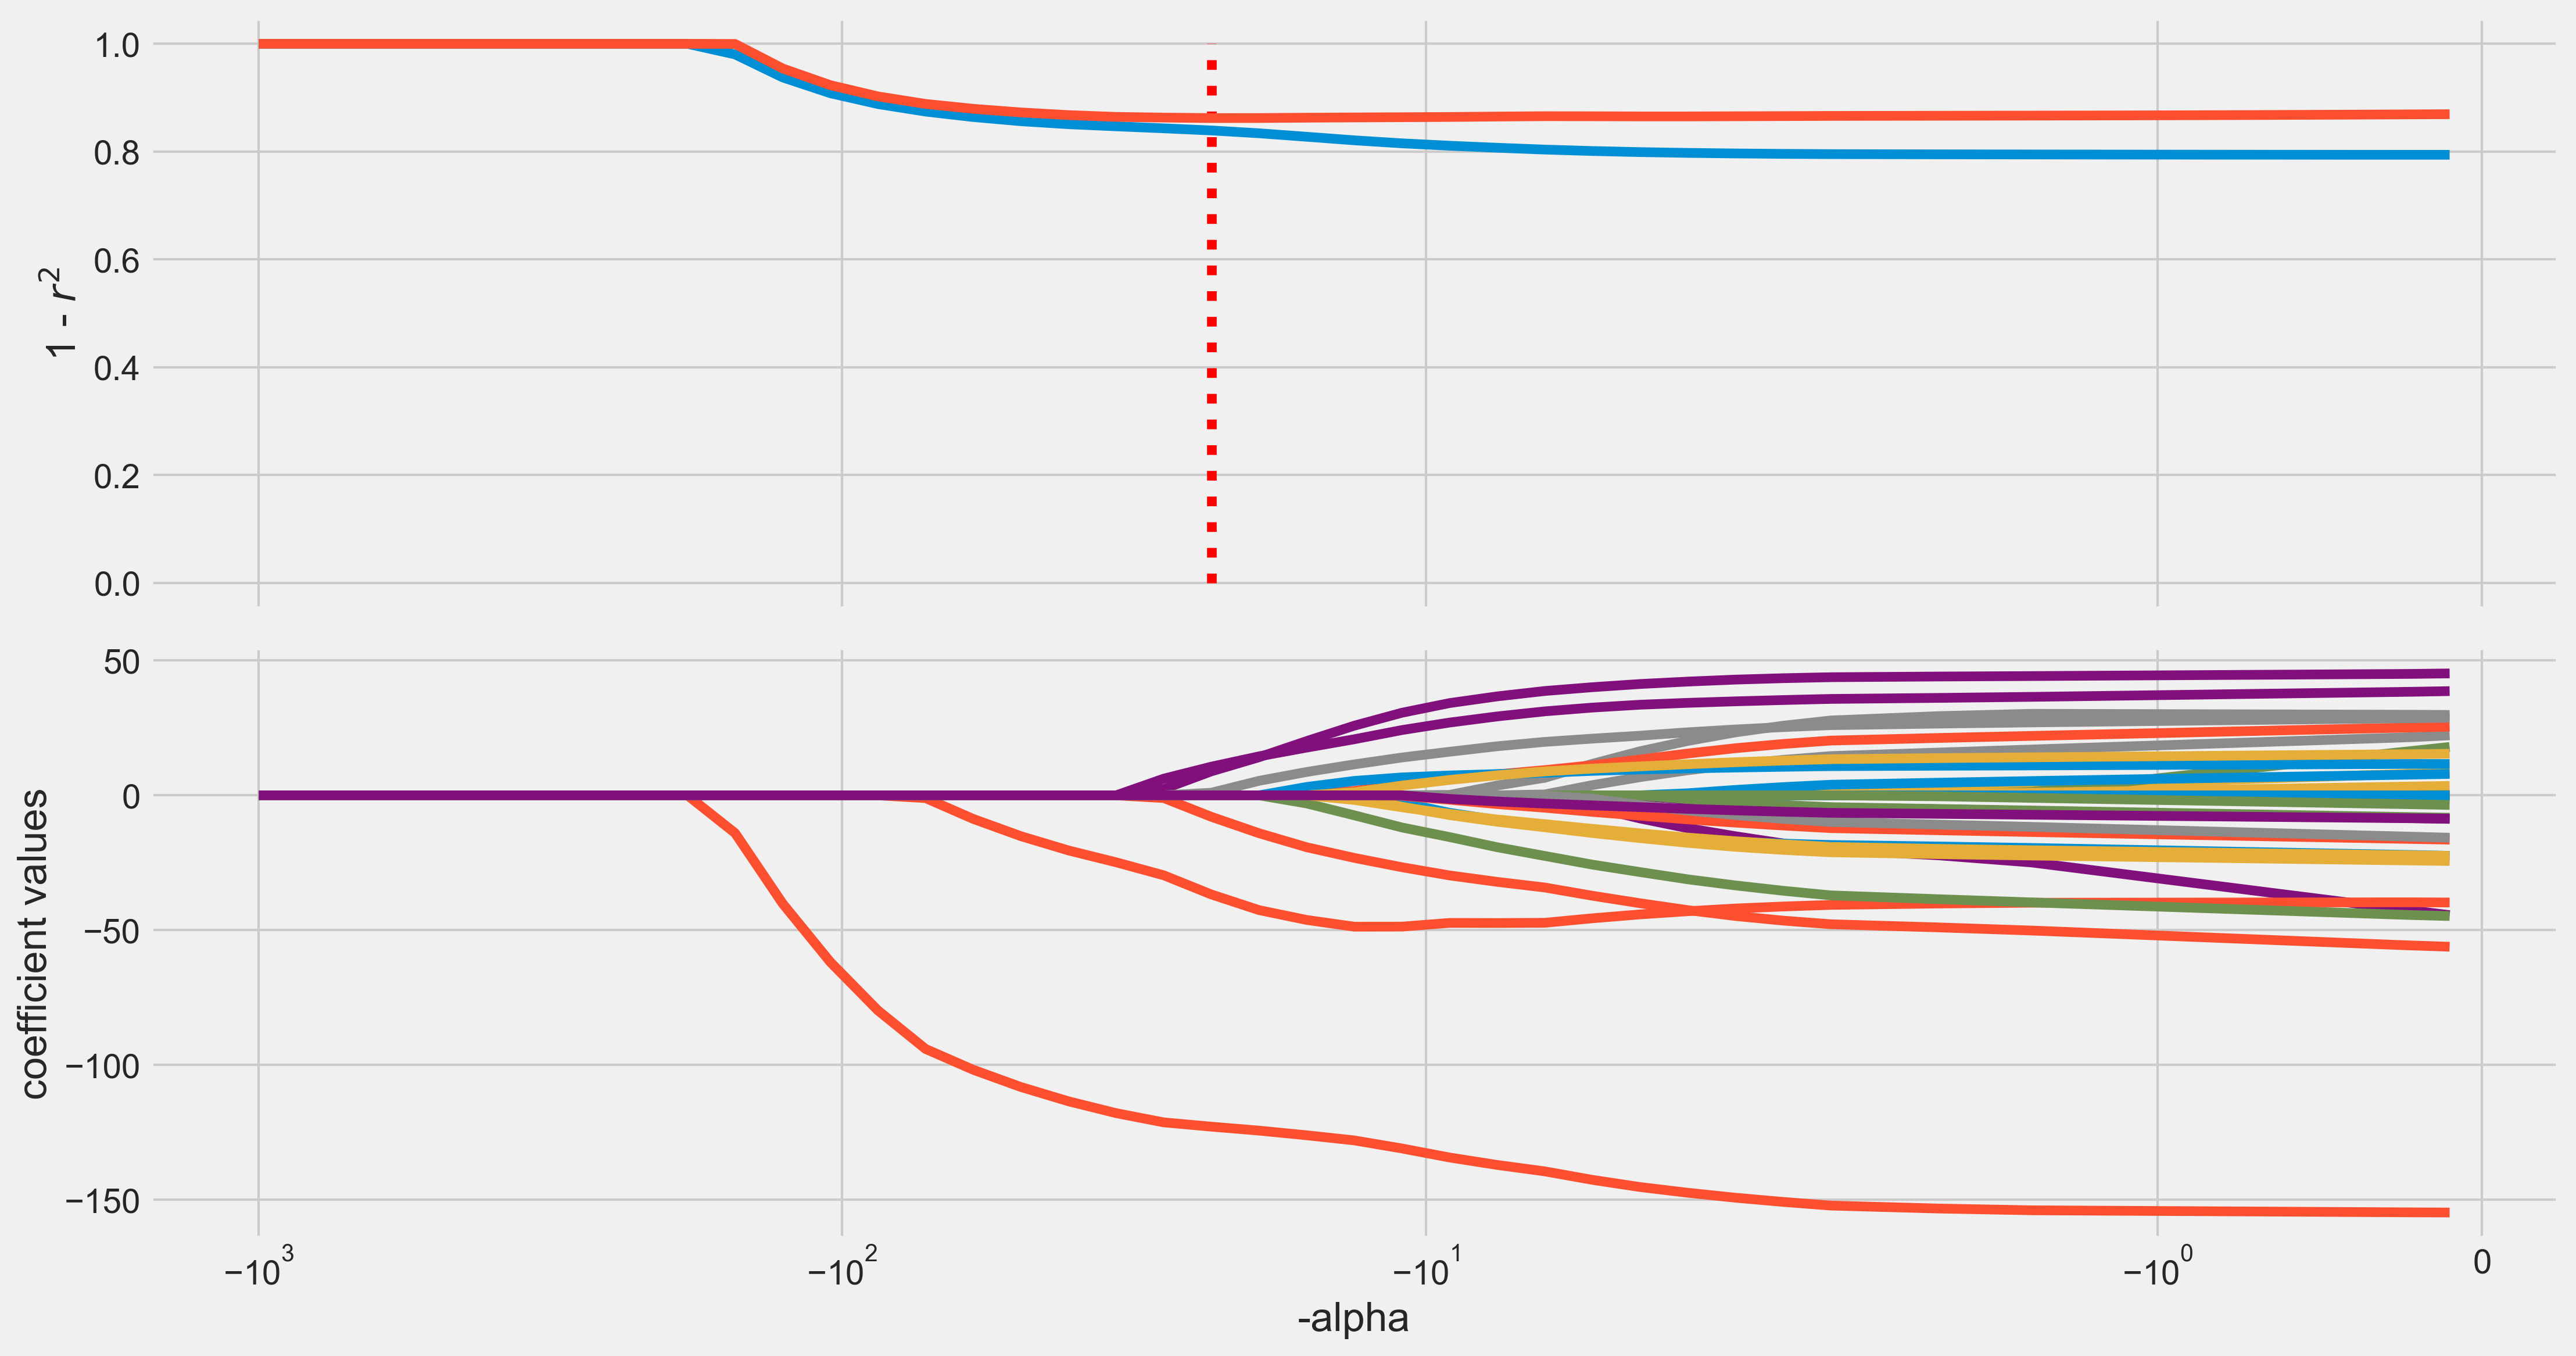

In [42]:
from sklearn.model_selection import cross_validate

lasso_pipe = pipeline.Pipeline([
    ("imp", preprocessing.Imputer()), 
    ("std", preprocessing.StandardScaler()),
    ("lasso", linear_model.Lasso())
])
fig, axes = plt.subplots(2,1, figsize=(15, 8), sharex=True, tight_layout=True)

# start lower -- .1
alphas = np.logspace(-1,3, num=50)
coefs = []
train_scores = []
test_scores = []
#fig, axes = plt.subplots(1,len(alphas), figsize=(20, 8), sharey=True)
for i, alpha in enumerate(alphas):
    lasso_pipe.set_params(lasso__alpha=alpha)
    cv_result = cross_validate(lasso_pipe, X=X, y=y, cv=10, return_train_score=True)
    train_scores.append(np.maximum(np.mean(cv_result['train_score']), 0))
    test_scores.append(np.maximum(np.mean(cv_result['test_score']), 0))
    lasso_pipe.fit(X_train, y_train)
    coefs.append(lasso_pipe.named_steps["lasso"].coef_)
    

coefs = np.squeeze(coefs, axis=1)
ax0 = axes.flat[0]
ax0.plot(-alphas, 1 - np.array(train_scores), label="train")
ax0.plot(-alphas, 1 - np.maximum(test_scores, 0), label="test")
best_i = np.argmax(test_scores)
ax0.vlines(-alphas[best_i], 0,1, colors="red", linestyles="dotted")
ax0.set_ylabel("1 - $r^2$")
ax1 = axes.flat[1]
ax1.plot(-alphas,coefs)
ax1.set_ylabel("coefficient values")
ax1.set_xlabel("-alpha")
ax1.set_xscale("symlog")
plt.xscale("symlog")

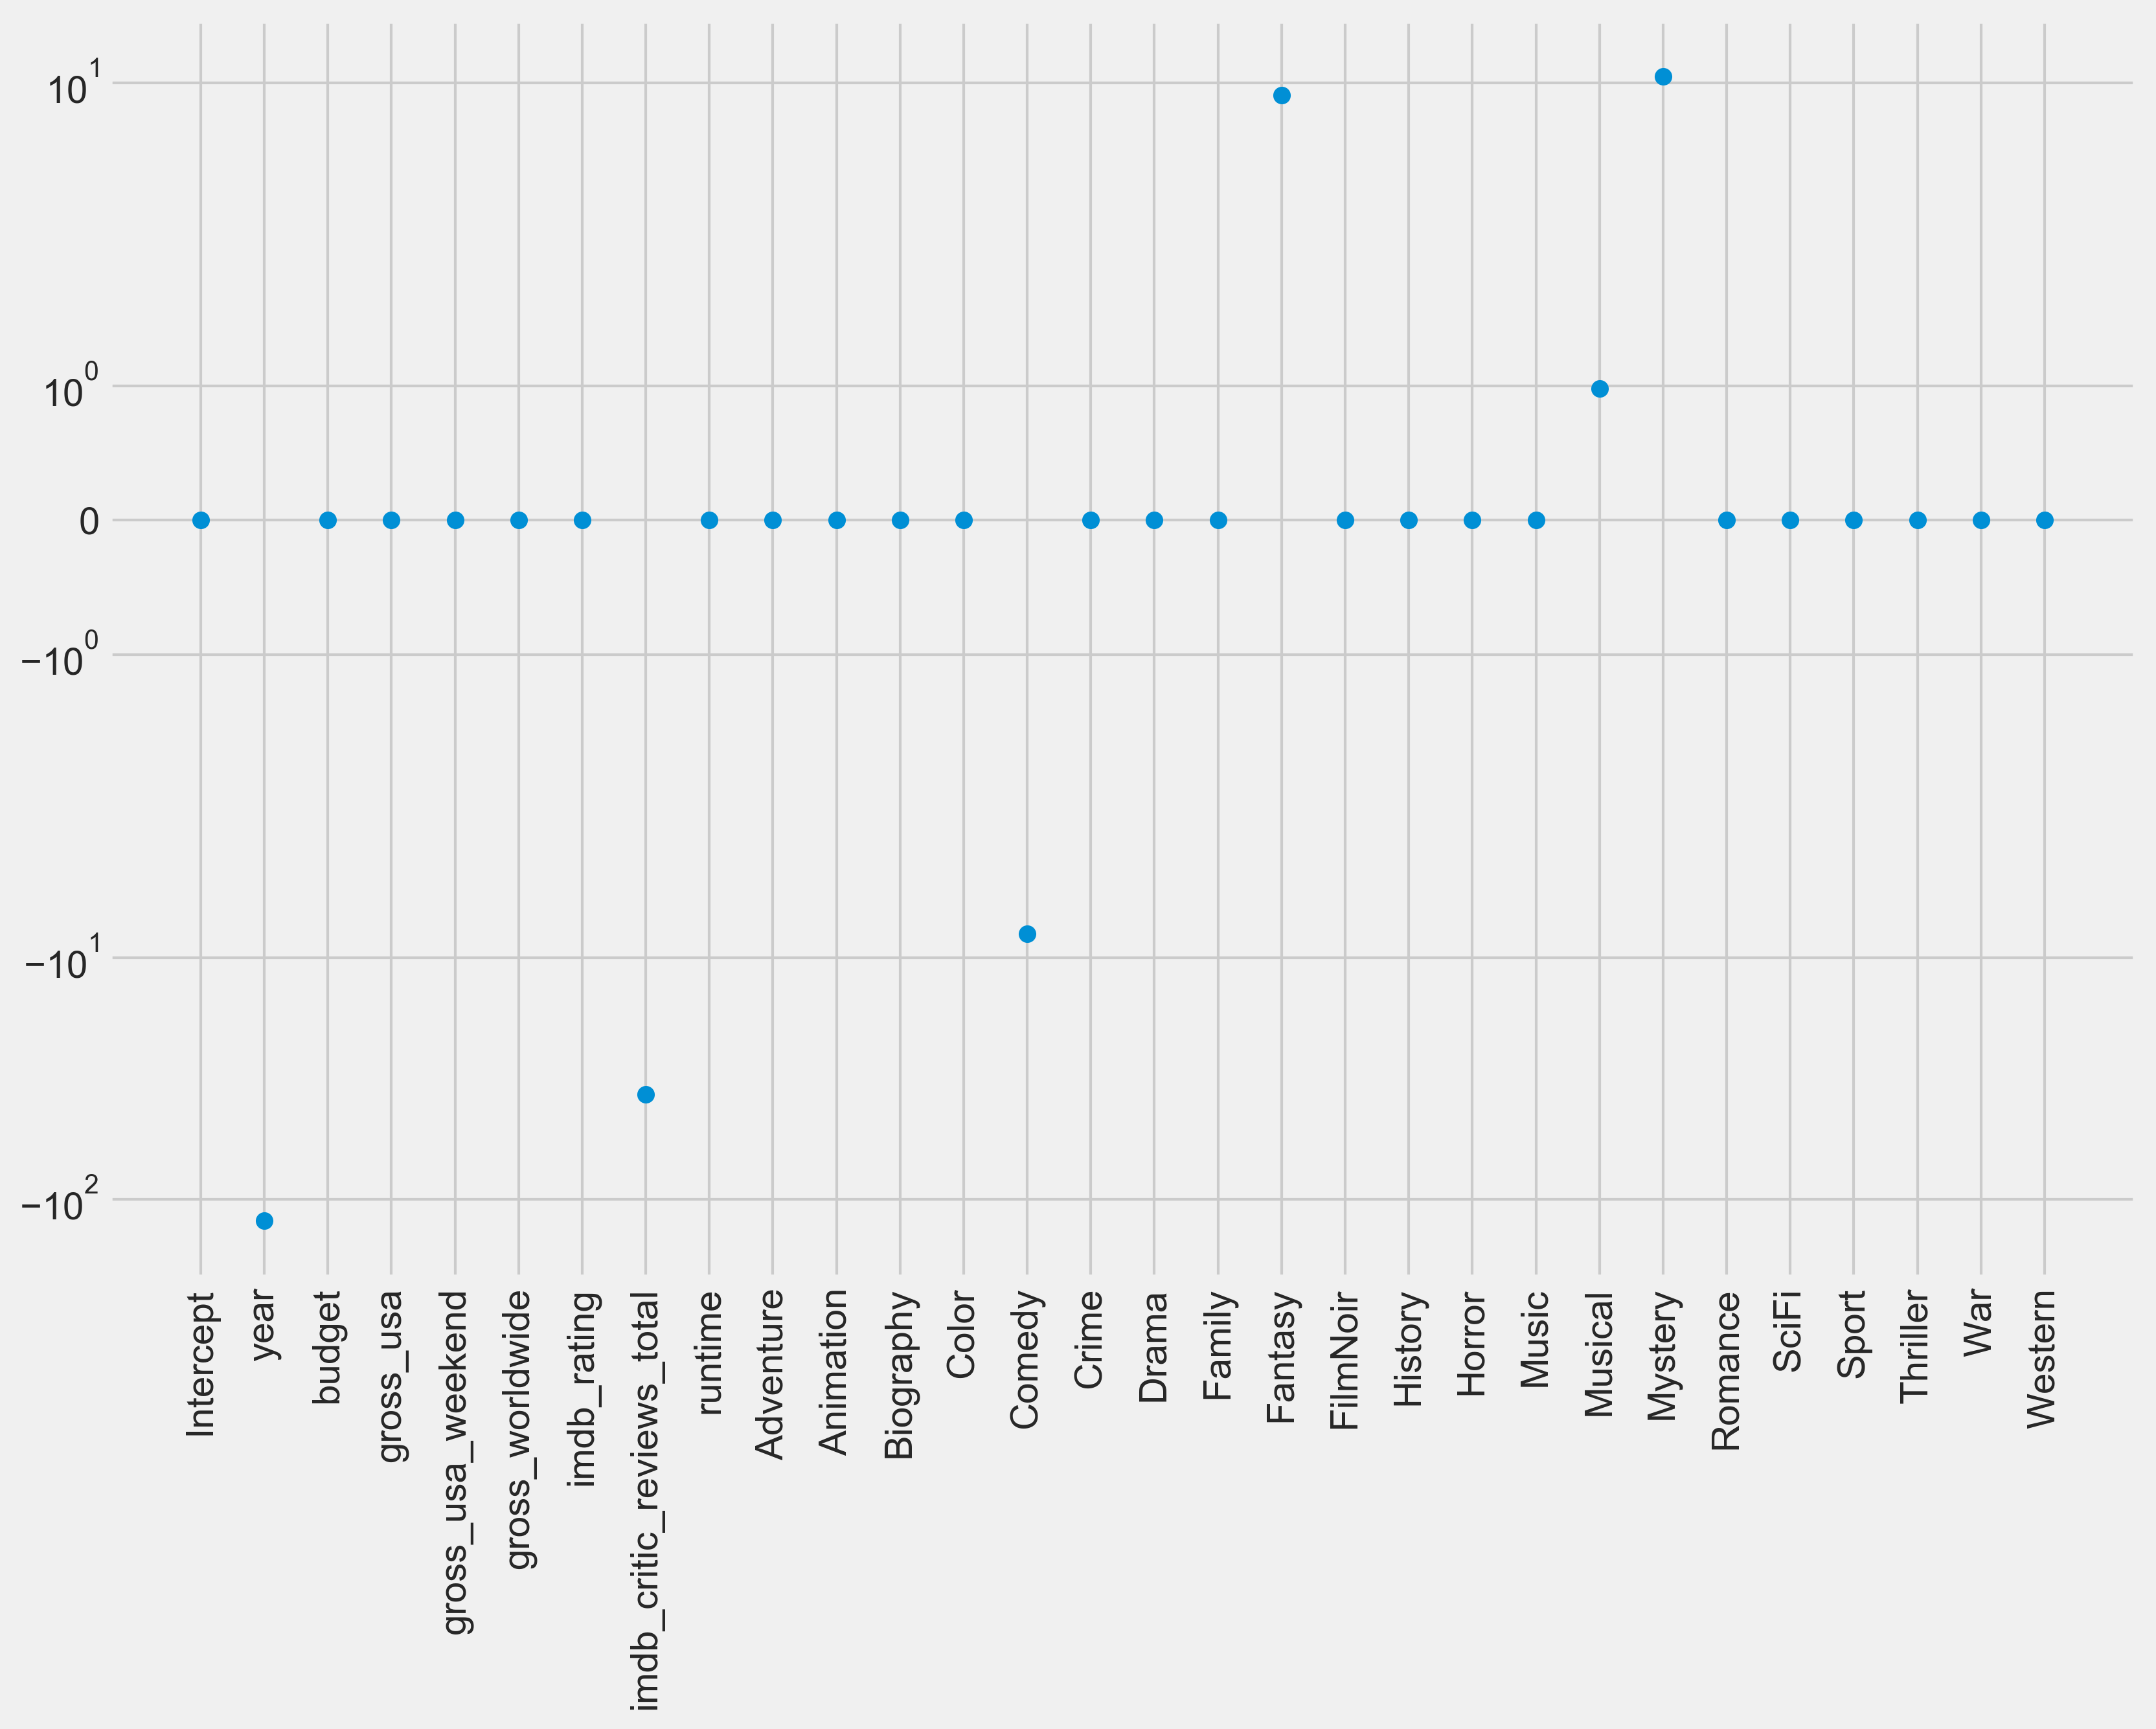

In [45]:
from matplotlib import rcParams
rcParams['figure.figsize'] = 12,8
rcParams['figure.dpi'] = 300
# ASK: how to log again?
best_c = coefs[best_i,:]
#plt.scatter(np.arange(len(best_c)), np.abs(best_c))
plt.scatter(np.arange(len(best_c)), best_c) # shows oppositie correlations -- useful for presentation
plt.xticks(np.arange(len(best_c)), X.columns, rotation=90);
# two columns with top x variables and create a new model with that 
plt.yscale("symlog")

# Learning Curve

/Users/justinblinder/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/justinblinder/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:298: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/Users/justinblinder/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/justinblinder/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/justinblinder/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less

/Users/justinblinder/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/justinblinder/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:298: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/Users/justinblinder/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/justinblinder/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/justinblinder/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less

train: 0.183, test: 0.127


/Users/justinblinder/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/justinblinder/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:298: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/Users/justinblinder/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/justinblinder/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/justinblinder/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less

/Users/justinblinder/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:298: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/Users/justinblinder/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/justinblinder/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/justinblinder/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
/Users/justinblinder/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using rav

/Users/justinblinder/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/justinblinder/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:298: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/Users/justinblinder/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/justinblinder/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/justinblinder/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less

/Users/justinblinder/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/justinblinder/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:298: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/Users/justinblinder/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/justinblinder/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/justinblinder/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less

/Users/justinblinder/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/justinblinder/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:298: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/Users/justinblinder/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/justinblinder/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/justinblinder/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less

/Users/justinblinder/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/justinblinder/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:298: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/Users/justinblinder/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/justinblinder/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/justinblinder/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less

/Users/justinblinder/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:298: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/Users/justinblinder/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/justinblinder/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/justinblinder/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
/Users/justinblinder/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using rav

/Users/justinblinder/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/justinblinder/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:298: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/Users/justinblinder/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/justinblinder/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/justinblinder/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less

/Users/justinblinder/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/justinblinder/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:298: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/Users/justinblinder/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/justinblinder/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/justinblinder/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less

/Users/justinblinder/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/justinblinder/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:298: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/Users/justinblinder/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/justinblinder/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/justinblinder/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less

/Users/justinblinder/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:298: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/Users/justinblinder/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/justinblinder/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/justinblinder/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
/Users/justinblinder/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using rav

/Users/justinblinder/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/justinblinder/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:298: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/Users/justinblinder/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/justinblinder/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/justinblinder/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less

/Users/justinblinder/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/justinblinder/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:298: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/Users/justinblinder/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/justinblinder/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/justinblinder/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less

/Users/justinblinder/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/justinblinder/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:298: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/Users/justinblinder/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/justinblinder/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/justinblinder/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less

/Users/justinblinder/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/justinblinder/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:298: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/Users/justinblinder/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/justinblinder/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/justinblinder/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less

/Users/justinblinder/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:298: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/Users/justinblinder/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/justinblinder/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/justinblinder/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
/Users/justinblinder/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using rav

/Users/justinblinder/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/justinblinder/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:298: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/Users/justinblinder/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/justinblinder/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/justinblinder/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less

/Users/justinblinder/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:298: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/Users/justinblinder/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/justinblinder/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/justinblinder/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
/Users/justinblinder/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using rav

/Users/justinblinder/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:298: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/Users/justinblinder/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/justinblinder/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/justinblinder/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
/Users/justinblinder/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using rav

/Users/justinblinder/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/justinblinder/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:298: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/Users/justinblinder/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/justinblinder/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/justinblinder/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less

/Users/justinblinder/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/justinblinder/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:298: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/Users/justinblinder/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/justinblinder/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/justinblinder/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less

/Users/justinblinder/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:298: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/Users/justinblinder/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/justinblinder/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/justinblinder/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
/Users/justinblinder/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using rav

/Users/justinblinder/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/justinblinder/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:298: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/Users/justinblinder/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/justinblinder/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/justinblinder/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less

/Users/justinblinder/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/justinblinder/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:298: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/Users/justinblinder/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/justinblinder/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/justinblinder/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less

/Users/justinblinder/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/justinblinder/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:298: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/Users/justinblinder/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/justinblinder/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/justinblinder/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less

/Users/justinblinder/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/justinblinder/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:298: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/Users/justinblinder/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/justinblinder/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/justinblinder/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less

/Users/justinblinder/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/justinblinder/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:298: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/Users/justinblinder/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/justinblinder/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/justinblinder/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less

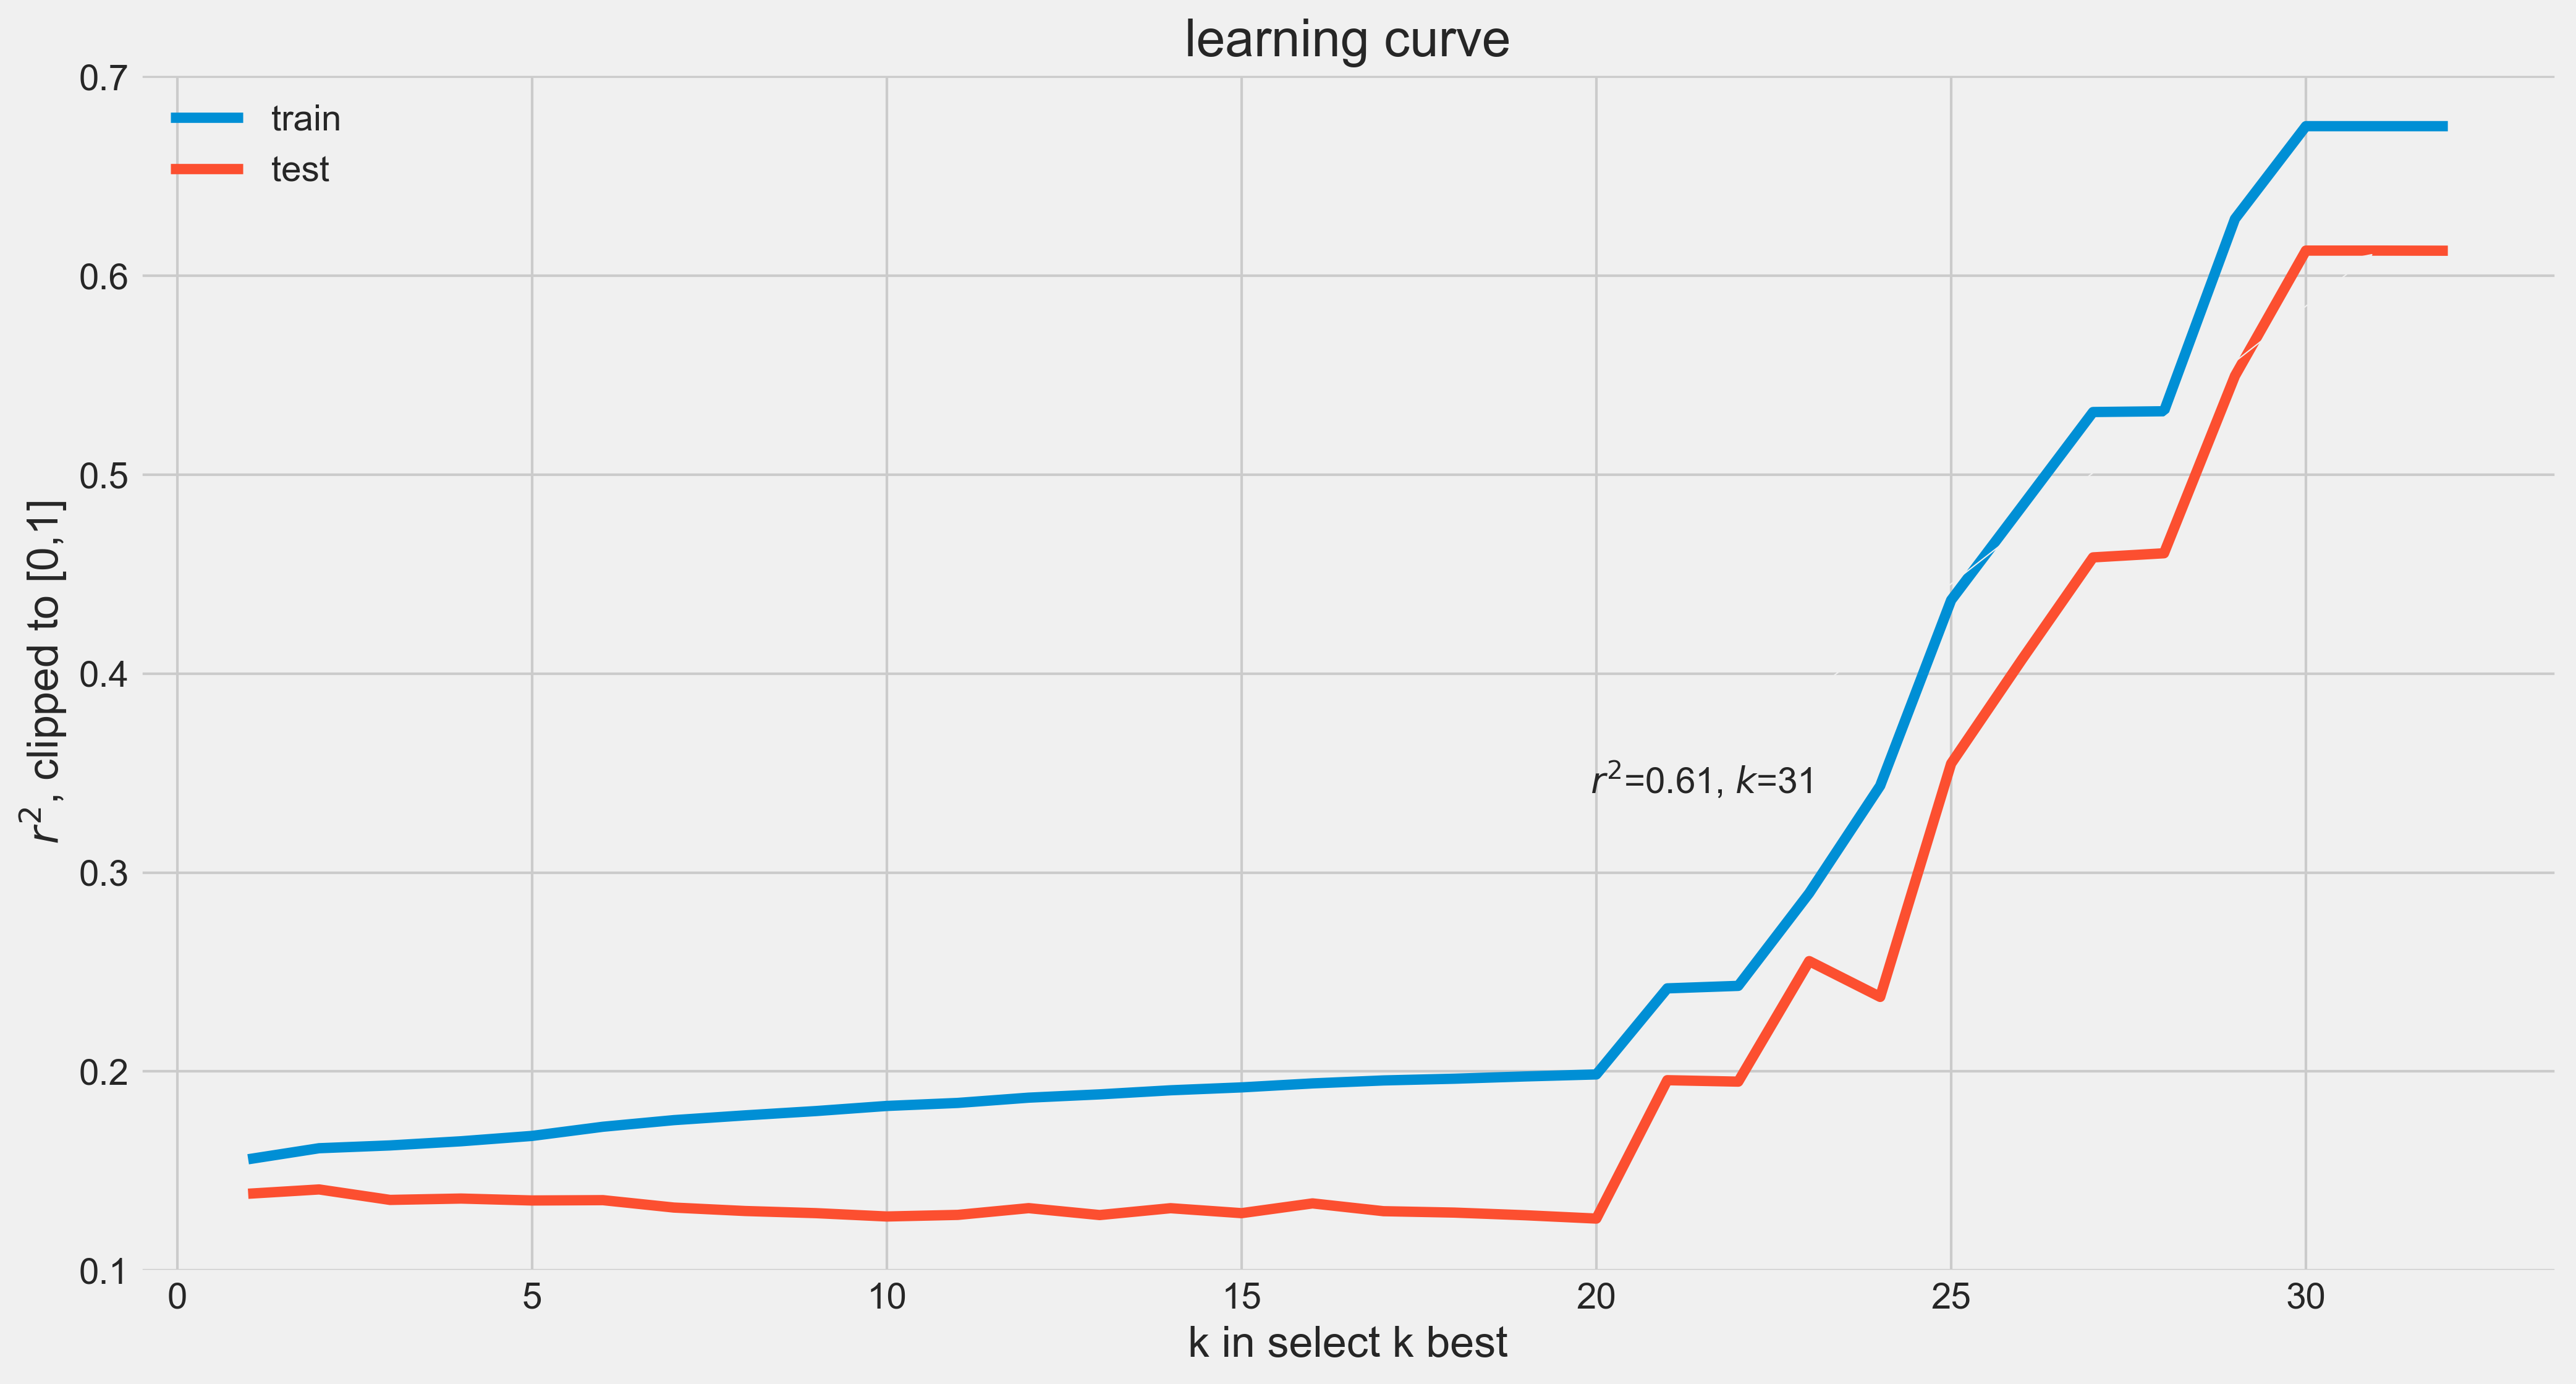

In [118]:
from sklearn import pipeline, feature_selection, model_selection, linear_model, preprocessing
select_pipe = pipeline.Pipeline(
    # some features have missing values so this fills in the mean for them
    # this imputer is lazy and often helpful but not always the best option
    [("imp", preprocessing.Imputer()), 
     # scale our features before linear models. it's good data hygiene 
     ("std", preprocessing.StandardScaler()),
     # we'll use select k best to adjust model complexity
     ("select",
      feature_selection.SelectKBest(
          score_func=feature_selection.f_regression)), 
     # our old friend <3
     ("lin", linear_model.LinearRegression())
    ])

select_pipe.fit(X,y)
select_pipe.score(X,y)

feat_support = select_pipe.named_steps["select"].get_support()
feat = X.columns[feat_support]
coef = select_pipe.named_steps["lin"].coef_



cv_result = model_selection.cross_validate(
        select_pipe, X=X, y=y, cv=10, return_train_score=True)
print(f"train: {np.mean(cv_result['train_score']):.3}, test: {np.mean(cv_result['test_score']):.3}")
#figsize(15, 8)


train_scores = []
test_scores = []
# define feature range
num_feats = len(X.columns)
feat_range = np.arange(num_feats)+1
# for each k in feat_range
for num_f in feat_range:
    # set pipeline params
    select_pipe.set_params(select__k=num_f)
    # get cross val scores
    cv_result = model_selection.cross_validate(
        select_pipe, X=X, y=y, cv=10, return_train_score=True)
    train_scores.append(np.maximum(np.mean(cv_result['train_score']), 0))
    test_scores.append(np.maximum(np.mean(cv_result['test_score']), 0))

# plot test vs train
plt.plot(feat_range, train_scores, label="train")
plt.plot(feat_range, test_scores, label="test")

# find index of best score
best_i = np.argmax(test_scores)
# annotate score
ann_xy = (feat_range[best_i], test_scores[best_i])
ann_text = f"$r^2$={test_scores[best_i]:.2}, $k$={feat_range[best_i]}"
plt.annotate(ann_text, xy=ann_xy, xytext=(.6,.4), textcoords='axes fraction',
            arrowprops=dict(arrowstyle="->"),
            )

plt.xlabel("k in select k best")
plt.ylabel("$r^2$, clipped to [0,1]")
plt.title("learning curve")
plt.legend();
#ASK: Is this accurate: in the middle?